<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula3a_fun%C3%A7%C3%A3o_de_ativa%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def criaDataset(n=20, slop=[2,1], intercept=0, dummy_features=0):
  X = np.random.uniform(size=(n,dummy_features+2))
  AUX = np.multiply(X[:,:2], slop)-[0, intercept]
  y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
  return X, y

slop=[-1,2]
intercept = 1
X, y = criaDataset(slop=slop, intercept=intercept)
X, y

(array([[0.48953249, 0.84794199],
        [0.33580329, 0.22533272],
        [0.70376579, 0.188402  ],
        [0.21238613, 0.59938998],
        [0.40446466, 0.33027609],
        [0.55254421, 0.5815617 ],
        [0.56559045, 0.43617224],
        [0.70848822, 0.52052868],
        [0.83662262, 0.69930412],
        [0.458482  , 0.41821699],
        [0.44994179, 0.40614799],
        [0.30518146, 0.10926964],
        [0.91033687, 0.81065927],
        [0.42841142, 0.26744411],
        [0.9772397 , 0.33332584],
        [0.04411328, 0.23698817],
        [0.97495383, 0.75605346],
        [0.83469076, 0.03947554],
        [0.09216095, 0.05677857],
        [0.37928948, 0.63135572]]),
 array([-1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1,
         1,  1, -1]))

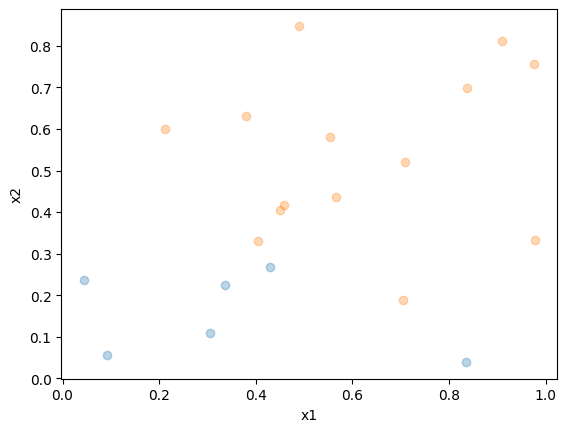

In [2]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.xlabel('x1')
  plt.ylabel('x2')
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], 'o', alpha=0.3)

plotDataset(X, y)

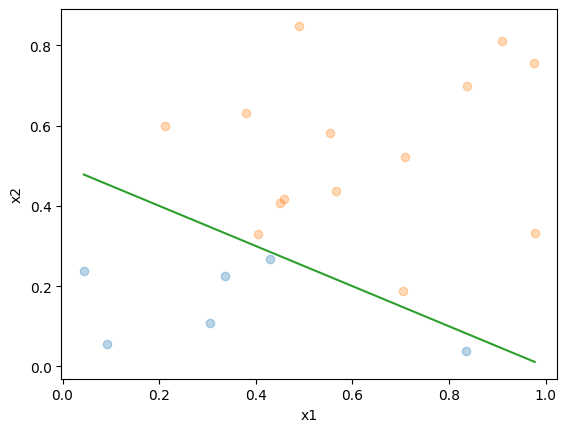

In [3]:
def plotHiperplano(X, y, vetor, intercept=0):
  x0min = min(X[:,0])
  x0max = max(X[:,0])
  xs = np.linspace(x0min, x0max, num=2)
  ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
  plt.plot(xs, ys)

plotDataset(X, y)
vetor_hiperplano = np.array(slop) * np.array([1, -1])
plotHiperplano(X, y, vetor_hiperplano, intercept)

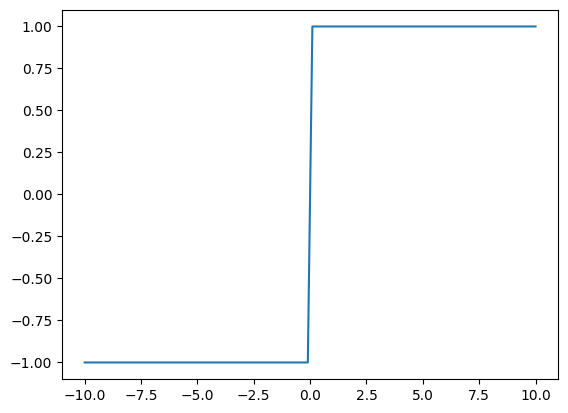

In [6]:
def sign(a):
  return (a >= 0) * 2 -1

a = np.linspace(-10,10,100)
out = sign(a)
plt.plot(a, out)
plt.show()

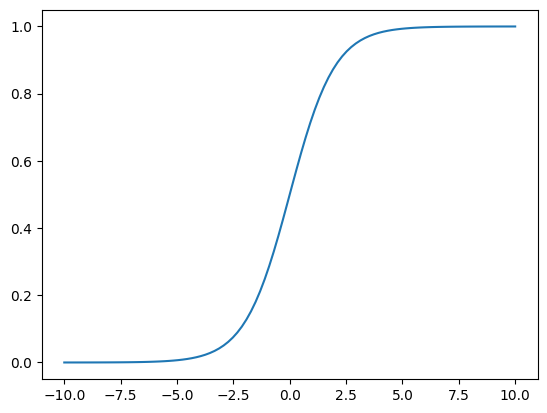

In [13]:
def sigmoid(a):
  return 1/(1 + np.exp(-a))

a = np.linspace(-10,10,100)
out = sigmoid(a)
plt.plot(a, out)
plt.show()

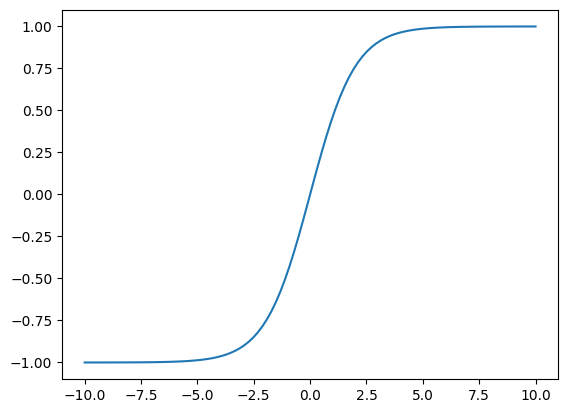

In [15]:
def tanh(a):
  return sigmoid(a)*2-1

a = np.linspace(-10,10,100)
out = tanh(a)
plt.plot(a, out)
plt.show()

In [24]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
  @abstractstaticmethod
  def custo(y, ypred):
    pass
  @abstractstaticmethod
  def gradiente(y, ypred, X):
    pass

class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - ypred)

class SmoothSurrogate(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return  np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return X.T @ ymarginais

from scipy.special import expit

class LogLikehood(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - (expit(ypred)*2-1))

In [21]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation=None):
    pass

class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=500, learning_rate=0.01,
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=X.shape[1])
    for _ in range(self.max_iter):
      ypred = X @ w
      erros = y - ypred
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w


In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.activation = sign
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.w = self.training_algorithm.getW(Xb, y)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    ypred = self.activation(a)
    return ypred


0.95
[ 2.77157062 -2.94538087 -6.41897452]
0.935


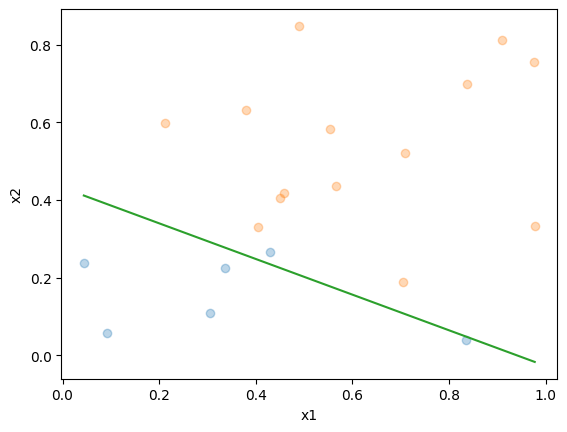

0.95
[ 2.81707625 -3.06620851 -6.37692634]
0.94


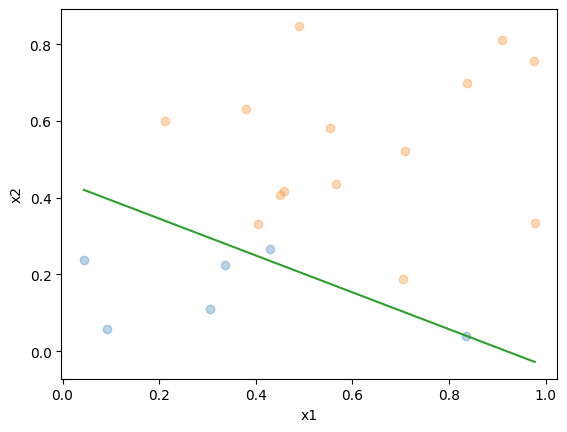

In [27]:
costs = [
    # WidrowHoff(),
    # SmoothSurrogate(),
    # HingeLoss(),
    LogLikehood(),
    ]
Xte, yte = criaDataset(200, slop, intercept)
for cost in costs:
  for _ in range(2):
    perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=cost))
    perceptron.fit(X, y)
    ypred = perceptron.predict(X)
    print(accuracy_score(y, ypred))
    print(perceptron.w)
    plotDataset(X, y)
    # plotDataset(X, ypred)
    plotHiperplano(X, y, perceptron.w[1:], perceptron.w[0])
    ypred = perceptron.predict(Xte)
    print(accuracy_score(yte, ypred))
    # print(perceptron.w)
    plt.show()
    # plotDataset(Xte, yte)
    # # plotDataset(X, ypred)
    # plotHiperplano(Xte, yte, perceptron.w[1:], perceptron.w[0])
    # plt.show()